In [1]:
import numpy as np
import numpy.fft as fft
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
from collections import defaultdict
from numpy import hamming

In [2]:
PATH = '../WESAD/'
SUBJECTS = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '13', '14', '15', '16', '17']
CHEST_SIGNALS = ['ECG', 'EMG', 'EDA', 'Resp', 'Temp', 'ACC']
CHEST_SAMPLING_RATE = 700

In [3]:
def read_subject_data(subject) :
    path = PATH + 'S' + subject + '/S' + subject + '.pkl'
    subject = pd.read_pickle(path)
    
    return subject

In [4]:
def visualize_raw(signal, duration, sampling_rate, title) :
    n = duration * sampling_rate
    l = len(signal)
    
    s = random.randint(0, l - n)
    df = pd.DataFrame(columns=['x', 'y'])
    df['x'] = np.arange(n)
    df['y'] = signal[s:s+n]
    
    plt.figure(figsize=(20, 5))
    sns.scatterplot(x = 'x', y = 'y', data = df, s = 3, color='0').set(title=title)

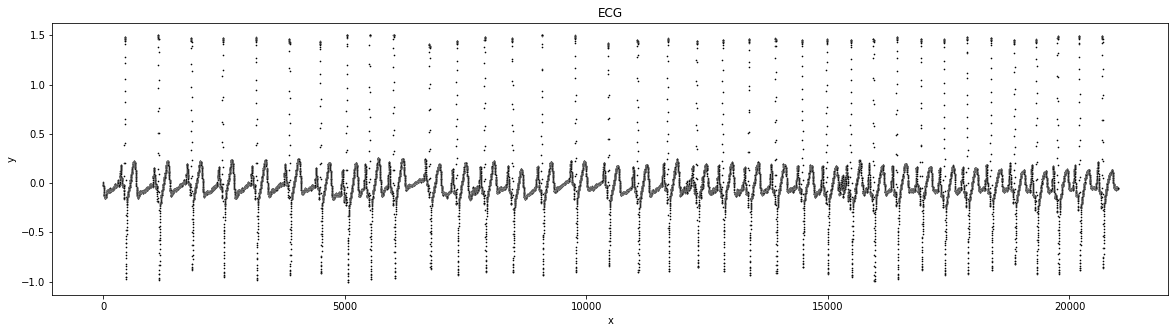

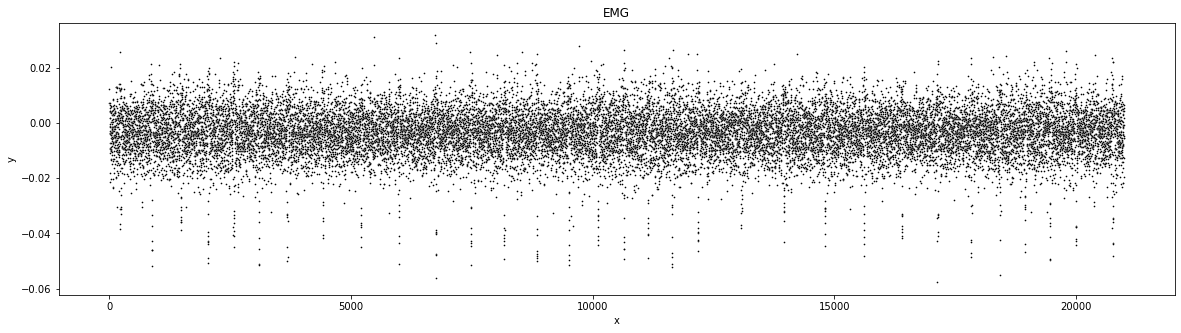

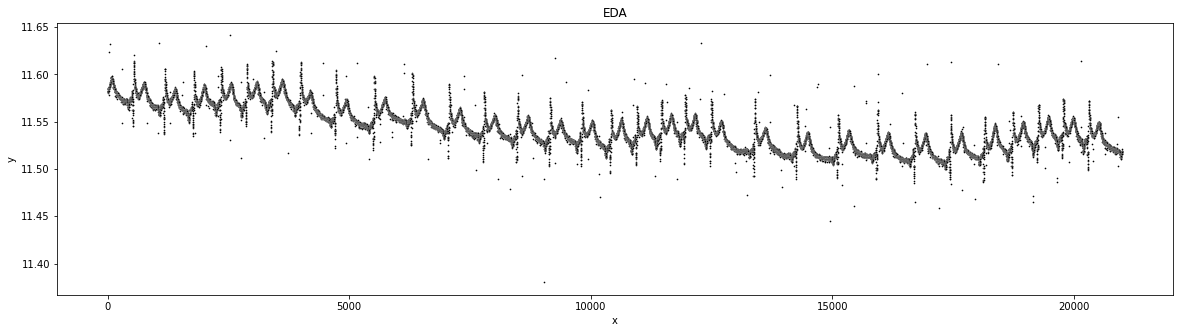

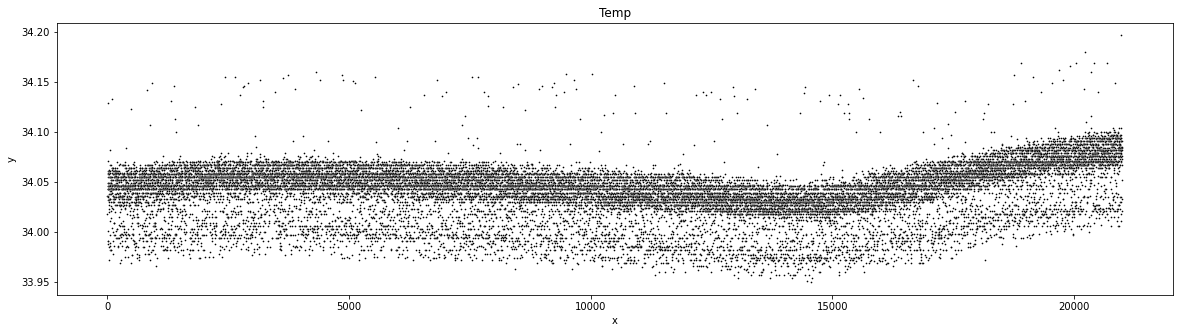

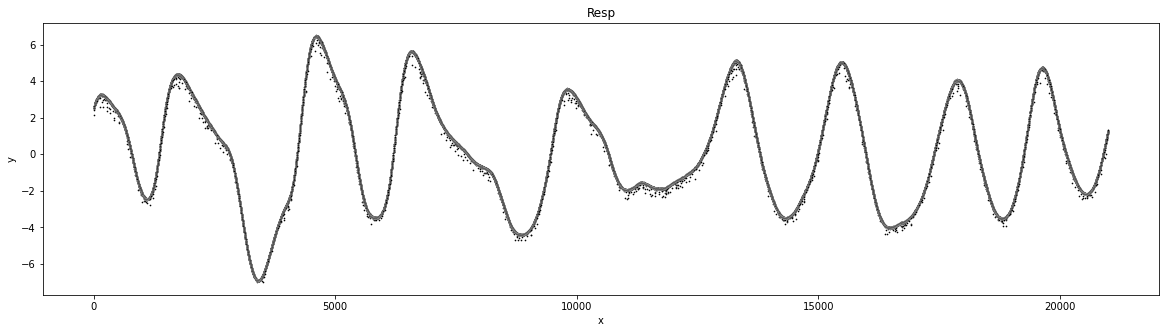

In [5]:
# Visualize the different chest signals
SAMPLING_RATE = 700
DURATION = 30

subject = random.choice(SUBJECTS)
subject_data = read_subject_data(subject)

chest_signals = subject_data['signal']['chest']

for signal_type in chest_signals :
    if signal_type == 'ACC' :
        continue
    
    signal = chest_signals[signal_type]
    visualize_raw(signal, DURATION, SAMPLING_RATE, signal_type)

In [15]:
# https://imotions.com/blog/eda/
# https://www.scitepress.org/Papers/2021/102446/102446.pdf
# https://sci-hub.ee/10.1016/j.cmpb.2020.105482
WINDOW_LEN = 20
OVERLAP = 0.75
NUM_FEATURES = 10

In [16]:
# Identify the continuous intervals for each label
def find_intervals(labels) :
    intervals = []

    l = len(labels)
    i = 0
    label = labels[0]

    for j in range(l):
        if label != labels[j]:
            intervals.append({
                'label' : label, 
                'beg' : i,
                'end' : j
                })
            i = j
            label = labels[j]

    intervals.append({
        'label' : label, 
        'beg' : i,
        'end' : l
    })

    return intervals    

In [17]:
def extract_fft_features(signal, num_features) :
    window = hamming(len(signal))
    signal *= window
    coeffs = fft.fft(signal)
    l = len(coeffs)
    freqs = fft.fftfreq(l)
    
    # Discard the negative elems
    l //= 2
    amps = np.abs(coeffs[0:l])
    freqs = np.abs(freqs[0:l])
    
    # Sort descending w.r.t amp   
    p = amps.argsort()[::-1]
    freqs = freqs[p]
    amps = amps[p]
    
    features = [[amps[i], freqs[i]] for i in range(num_features)]    
    return np.array(features)

In [18]:
def normalize_fft_features(train_features, test_features) :
    feature_max = np.max(train_features, axis=0)
    feature_min = np.min(train_features, axis=0)
    feature_diff = feature_max - feature_min
    train_features -= feature_min
    test_features -= feature_min
    train_features = np.divide(train_features, feature_diff, out=np.zeros_like(train_features), where=feature_diff!=0)
    test_features = np.divide(test_features, feature_diff, out=np.zeros_like(test_features), where=feature_diff!=0)
    
    return train_features, test_features

In [19]:
TRANSIENT = 0
BASELINE = 1
STRESS = 2
AMUSEMENT = 3
MEDITATION = 4
IGNORE = 5

def extract_signal_features(signal, intervals, sampling_rate, window_len = WINDOW_LEN, overlap = OVERLAP, num_features = NUM_FEATURES) :
    segment_size = sampling_rate * window_len
    signal_features = {
        BASELINE : [],
        STRESS : [],
        AMUSEMENT : [],
        MEDITATION : []
    }
    
    baseline_av = 0
    
    for interval in intervals :
        label = interval['label']
        beg = interval['beg']
        end = interval['end']
        
        signal_of_interest = signal[beg:end]  
        
        if label >= IGNORE or label == TRANSIENT:
            baseline_av = (np.mean(signal_of_interest) + baseline_av)/2
            continue      
            
        if label == BASELINE :
            baseline_av = (np.mean(signal_of_interest) + baseline_av)/2
        
        signal_of_interest -= baseline_av
        
        l = end - beg        
        while l >= segment_size:
            segment = signal_of_interest[int(l - segment_size) : l]
            l -= int((1 - overlap) * segment_size)
            
            segment_features = extract_fft_features(segment, num_features)            
            signal_features[label].append(segment_features)
        
    return signal_features

In [20]:
def get_chest_signal_dataset(subjects, signal_type) :
    dataset = defaultdict(list)
    for subject in subjects :
        subject_data = read_subject_data(subject)
        intervals = find_intervals(subject_data['label'])
        
        signal = np.array(subject_data['signal']['chest'][signal_type]).flatten()
        
        signal_features = extract_signal_features(signal, intervals, CHEST_SAMPLING_RATE)
        
        for label, feature_vecs in signal_features.items() :
            dataset[label] += list(feature_vecs)
            
    features_dataset = [] 
    label_dataset = []
    
    for label, feature_vecs in dataset.items() :
        for features in feature_vecs :
            features_dataset.append(features)
            label_dataset.append(label)

    return np.array(features_dataset), np.array(label_dataset)

In [21]:
# Get Joint test-train  Datasets combining all signals

def get_agg_chest_signal_dataset(subjects) :
    agg_feature_dataset = []
    agg_labels_dataset = []
    
    for subject in subjects :
        subject_data = read_subject_data(subject)
        intervals = find_intervals(subject_data['label'])
        
        subject_agg = {
            BASELINE : [],
            STRESS : [],
            AMUSEMENT : [],
            MEDITATION : []
        }
        
        for signal_type in CHEST_SIGNALS :
            if signal_type == 'ACC' :
                continue
                
            signal = np.array(subject_data['signal']['chest'][signal_type]).flatten()
            signal_features = extract_signal_features(signal, intervals, CHEST_SAMPLING_RATE)
            
            for label, features in signal_features.items() :
                subject_agg[label].append(features)
                
        for label in subject_agg :
            subject_agg[label] = np.stack(subject_agg[label], axis = 1)
            
        for label, feature_aggs in subject_agg.items() :
            for feature_agg in feature_aggs :
                agg_feature_dataset.append(feature_agg)
                agg_labels_dataset.append(label)

    return agg_feature_dataset, agg_labels_dataset

In [22]:
# Visualize Datasets
def visualize_dataset(features, labels) :
    features = np.array(features)
    amps = np.log10(features[:, :, 0].flatten())
    freqs  = features[:, :, 1].flatten()
    labels = np.repeat(np.array(labels), NUM_FEATURES)
    
    df = pd.DataFrame()
    df['Amp'] = amps
    df['Freq'] = freqs
    df['Label'] = labels
    
    for label, group in df.groupby('Label') :
        plt.figure(figsize=(20, 20))
        sns.scatterplot(x = 'Freq', y = 'Amp', data = group, palette='bright').set(title=label)
    
    plt.figure(figsize=(20, 20))
    sns.scatterplot(x = 'Freq', y = 'Amp', hue = 'Label', style='Label', data = df, palette='bright')

In [23]:
# Get ECG Test-Train Datasets

TRAIN_TEST_RATIO = 0.1

np.random.shuffle(SUBJECTS)
num_subjects = len(SUBJECTS)
k = int ((1 - TRAIN_TEST_RATIO) * num_subjects)

train_features, train_labels = get_agg_chest_signal_dataset(SUBJECTS[0 : k])
test_features, test_labels = get_agg_chest_signal_dataset(SUBJECTS[k : num_subjects])
train_features, test_features = normalize_fft_features(train_features, test_features)

In [39]:
visualize_dataset(train_features, train_labels)

<ipython-input-22-ffa83333a23d>:4: RuntimeWarning: divide by zero encountered in log10
  amps = np.log10(features[:, :, 0].flatten())


ValueError: Length of values (308240) does not match length of index (77060)

In [24]:
def encode_labels(labels) :
    encoder = {
        1 : [1, 0, 0, 0],
        2 : [0, 1, 0, 0],
        3 : [0, 0, 1, 0],
        4 : [0, 0, 0, 1]
    }
    
    return np.array([np.array(encoder[l]) for l in labels])

In [25]:
train_labels = encode_labels(train_labels)
test_labels = encode_labels(test_labels)

In [26]:
@tf.custom_gradient
def my_func(x) :
    z = 1/(1+tf.exp(x))
    def grad(upstream) :
        return upstream * ((2 - x)*z - 2*x*(z**3) + (3*x - 2)*(z**2))
    return 1 + ((x-1)*z - x*(z**2)), grad

In [27]:
x = tf.constant(0.1)
with tf.GradientTape() as g:
    g.watch(x)
    z = my_func(x)
print(z)

tf.Tensor(0.54991686, shape=(), dtype=float32)


In [28]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(5, 10, 2)),
    keras.layers.Conv2D(4, kernel_size=(1,2), strides=(1, 2), activation=my_func),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(5, kernel_size=(1,2), strides=(1, 2), activation=my_func),
    keras.layers.Conv2D(2, kernel_size=(2,2), activation=my_func),
    keras.layers.Flatten(),
    keras.layers.Dense(units=8,  activation=my_func),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=6,  activation=my_func),
    keras.layers.Dense(units=4,  activation=my_func),
    keras.layers.Dense(units=4,  activation=my_func),
    keras.layers.Dense(units=4,  activation=my_func),
    keras.layers.Dense(units=4)
])

# (91, 85)

In [29]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(5, 10, 2)),
    keras.layers.Conv2D(2, kernel_size=(1,2), activation=my_func),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(3, kernel_size=(1,2), strides=(1, 2), activation=my_func),
    keras.layers.Conv2D(2, kernel_size=(2,2), strides=(1, 2), activation=my_func),
    keras.layers.Flatten(),
    keras.layers.Dense(units=12,  activation=my_func),
    keras.layers.Dense(units=6,  activation=my_func),
    keras.layers.Dense(units=4)
])
# (92, 88)

In [30]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(5, 10, 2)),
    keras.layers.Conv2D(2, kernel_size=(1,2), activation=my_func),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(3, kernel_size=(1,2), strides=(1, 2), activation=my_func),
    keras.layers.Conv2D(2, kernel_size=(2,2), strides=(1, 2), activation=my_func),
    keras.layers.Conv2D(2, kernel_size=(2,2), strides=(1, 2), activation=my_func),
    keras.layers.Flatten(),
    keras.layers.Dense(units=12,  activation=my_func),
    keras.layers.Dense(units=6,  activation=my_func),
    keras.layers.Dense(units=4)
])
# (90, 86)

In [31]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(5, 10, 2)),
    keras.layers.Conv2D(2, kernel_size=(1,2), activation=my_func),
    keras.layers.Conv2D(3, kernel_size=(1,2), strides=(1, 2), activation=my_func),
    keras.layers.Conv2D(2, kernel_size=(2,2), strides=(1, 2), activation=my_func),
    keras.layers.Conv2D(2, kernel_size=(2,2), strides=(1, 2), activation=my_func),
    keras.layers.Flatten(),
    keras.layers.Dense(units=12,  activation=my_func),
    keras.layers.Dense(units=6,  activation=my_func),
    keras.layers.Dense(units=4)
])
# (93, 91)

In [32]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(5, 10, 2)),
    keras.layers.Conv2D(2, kernel_size=(1,2), activation=my_func),
    keras.layers.Conv2D(3, kernel_size=(1,2), strides=(1, 2), activation=my_func),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(3, kernel_size=(2,2), strides=(1, 2), activation=my_func),
    keras.layers.Conv2D(2, kernel_size=(2,2), strides=(1, 1), activation=my_func),
    keras.layers.Flatten(),
    keras.layers.Dense(units=12,  activation=my_func),
    keras.layers.Dense(units=6,  activation=my_func),
    keras.layers.Dense(units=4)
])

In [33]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(5, 10, 2)),
    keras.layers.Conv2D(2, kernel_size=(1,2),strides=(1, 2), activation=my_func),
    keras.layers.Conv2D(2, kernel_size=(2,2), strides=(1, 2), activation=my_func),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(2, kernel_size=(2,2), strides=(1, 1), activation=my_func),
    keras.layers.Flatten(),
    keras.layers.Dense(units=8,  activation=my_func),
    keras.layers.Dense(units=4)
])

In [34]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(5, 10, 2)),
    keras.layers.Conv2D(3, kernel_size=(1,2),strides=(1, 2), activation=my_func),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(2, kernel_size=(2,2), strides=(1, 2), activation=my_func),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(2, kernel_size=(2,2), strides=(1, 1), activation=my_func),
    keras.layers.Flatten(),
    keras.layers.Dense(units=4,  activation=my_func),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=4,  activation=my_func),
    keras.layers.Dense(units=4)
])

In [35]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 5, 5, 3)           15        
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 5, 3)           12        
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 4, 2, 2)           26        
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 2, 2)           8         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 3, 1, 2)           18        
_________________________________________________________________
flatten_6 (Flatten)          (None, 6)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 4)                

In [36]:
model.compile(optimizer='adam', loss=tf.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [37]:
print(np.shape(train_features), np.shape(train_labels), np.shape(test_features), np.shape(test_labels))

(7706, 5, 10, 2) (7706, 4) (1186, 5, 10, 2) (1186, 4)


In [38]:
model.fit(train_features, train_labels, epochs=10000, batch_size = 32, shuffle = True, verbose=1,
              validation_data=(test_features,  test_labels))

Epoch 1/10000
241/241 [==============================] - 1s 3ms/step - loss: 1.3150 - accuracy: 0.3810 - val_loss: 1.3253 - val_accuracy: 0.3938
Epoch 2/10000
241/241 [==============================] - 0s 1ms/step - loss: 1.0983 - accuracy: 0.6320 - val_loss: 0.9744 - val_accuracy: 0.5809
Epoch 3/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.8069 - accuracy: 0.7191 - val_loss: 0.6989 - val_accuracy: 0.8094
Epoch 4/10000
241/241 [==============================] - 0s 1ms/step - loss: 0.6682 - accuracy: 0.7582 - val_loss: 0.5962 - val_accuracy: 0.8297
Epoch 5/10000
241/241 [==============================] - 0s 1ms/step - loss: 0.5893 - accuracy: 0.7830 - val_loss: 0.6079 - val_accuracy: 0.7605
Epoch 6/10000
241/241 [==============================] - 0s 1ms/step - loss: 0.5309 - accuracy: 0.8122 - val_loss: 0.5058 - val_accuracy: 0.8457
Epoch 7/10000
241/241 [==============================] - 0s 1ms/step - loss: 0.4895 - accuracy: 0.8321 - val_loss: 0.4663 - val_ac

241/241 [==============================] - 1s 2ms/step - loss: 0.2227 - accuracy: 0.9153 - val_loss: 0.5323 - val_accuracy: 0.8381
Epoch 58/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.2195 - accuracy: 0.9149 - val_loss: 0.5323 - val_accuracy: 0.8331
Epoch 59/10000
241/241 [==============================] - 1s 2ms/step - loss: 0.2256 - accuracy: 0.9189 - val_loss: 0.5934 - val_accuracy: 0.8196
Epoch 60/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.2180 - accuracy: 0.9219 - val_loss: 0.6038 - val_accuracy: 0.8221
Epoch 61/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.2206 - accuracy: 0.9184 - val_loss: 0.5876 - val_accuracy: 0.8179
Epoch 62/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.2197 - accuracy: 0.9177 - val_loss: 0.6093 - val_accuracy: 0.8212
Epoch 63/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.2228 - accuracy: 0.9176 - val_loss: 0.5635 - val_accuracy: 

241/241 [==============================] - 0s 2ms/step - loss: 0.2124 - accuracy: 0.9225 - val_loss: 0.5168 - val_accuracy: 0.8423
Epoch 114/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.2077 - accuracy: 0.9232 - val_loss: 0.5485 - val_accuracy: 0.8415
Epoch 115/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.2075 - accuracy: 0.9250 - val_loss: 0.5932 - val_accuracy: 0.8331
Epoch 116/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.2093 - accuracy: 0.9223 - val_loss: 0.5943 - val_accuracy: 0.8246
Epoch 117/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.2060 - accuracy: 0.9256 - val_loss: 0.5753 - val_accuracy: 0.8364
Epoch 118/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.2058 - accuracy: 0.9245 - val_loss: 0.5998 - val_accuracy: 0.8347
Epoch 119/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.2074 - accuracy: 0.9250 - val_loss: 0.5744 - val_accu

Epoch 169/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.2056 - accuracy: 0.9238 - val_loss: 0.5110 - val_accuracy: 0.8440
Epoch 170/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.2010 - accuracy: 0.9242 - val_loss: 0.5514 - val_accuracy: 0.8423
Epoch 171/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.2030 - accuracy: 0.9246 - val_loss: 0.5938 - val_accuracy: 0.8339
Epoch 172/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.2080 - accuracy: 0.9254 - val_loss: 0.5847 - val_accuracy: 0.8331
Epoch 173/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.2020 - accuracy: 0.9234 - val_loss: 0.5666 - val_accuracy: 0.8390
Epoch 174/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.2064 - accuracy: 0.9242 - val_loss: 0.5555 - val_accuracy: 0.8415
Epoch 175/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.2049 - accuracy: 0.9232 - val_loss: 0

Epoch 225/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.1953 - accuracy: 0.9281 - val_loss: 0.5349 - val_accuracy: 0.8474
Epoch 226/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.1977 - accuracy: 0.9260 - val_loss: 0.5370 - val_accuracy: 0.8432
Epoch 227/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.2024 - accuracy: 0.9259 - val_loss: 0.6063 - val_accuracy: 0.8280
Epoch 228/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.2003 - accuracy: 0.9250 - val_loss: 0.5345 - val_accuracy: 0.8415
Epoch 229/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.2045 - accuracy: 0.9245 - val_loss: 0.5356 - val_accuracy: 0.8406
Epoch 230/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.2032 - accuracy: 0.9219 - val_loss: 0.5304 - val_accuracy: 0.8449
Epoch 231/10000
241/241 [==============================] - 0s 2ms/step - loss: 0.1978 - accuracy: 0.9276 - val_loss: 0

KeyboardInterrupt: 

In [ ]:
import datetime
! rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [423]:
%reload_ext tensorboard

In [424]:
%tensorboard --logdir logs/fit

In [553]:
model.evaluate(test_features,  test_labels, verbose=2)

37/37 - 0s - loss: 0.4320 - accuracy: 0.8794


[0.43198782205581665, 0.8794143199920654]

In [554]:
model.save('Model_II')

INFO:tensorflow:Assets written to: Model_II/assets


In [1095]:
# import pickle
import pickle

train_features_file = open('train_features_file', 'wb')
test_features_file = open('test_features_file', 'wb')
train_labels_file = open('train_labels_file', 'wb')
test_labels_file = open('test_labels_file', 'wb')

pickle.dump(train_features, train_features_file)
pickle.dump(test_features, test_features_file)
pickle.dump(train_labels, train_labels_file)
pickle.dump(test_labels, test_labels_file)

train_features_file.close()
test_features_file.close()
train_labels_file.close()
test_labels_file.close()

In [ ]:
print(len(train_features), len(test_features))

In [ ]:
t1 = np.array([[[1, 9], [3, 4], [10, 12]], [[5, 6], [7, 8], [13, 11]]])
t2 = np.array([[2, 3], [3, 4]])

t3 = np.max(t1, axis=0)
print(t3)

In [ ]:
np.stack([t1, t1], axis=1)

In [ ]:
np.mean(t1, axis = 0)

In [ ]:
np.std(t1, axis = 0)

In [ ]:
d[1]

In [ ]:
t1[:, :, 0].flatten()

In [ ]:
a, b = zip(*train_dataset.items())

In [ ]:
len(train_features)

In [ ]:
SUBJECTS

In [ ]:
train_features[10]

In [ ]:
num_subjects

In [828]:
np.random.choice(np.arange(23, 30))

27